In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import cvxpy as cp
from scipy.stats import poisson, uniform, expon, pareto
from scipy.optimize import minimize, fsolve
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex
from scipy.optimize import least_squares

In [343]:
def getEquilBids(cs, a, guess=None):
    n = len(cs)
    bs = [sp.Symbol('b{}'.format(i)) for i in range(n)]
    
    denom = sum([bi**(-a) for bi in bs])
    xs    = [bi**(-a)/denom for bi in bs]
    us    = [(bs[i] - cs[i])*xs[i] for i in range(n)]
    diffs = [sp.diff(us[i], bs[i]) for i in range(n)]
    funcs = [sp.lambdify(bs, diffs[i]) for i in range(n)]
    
    def eqs(bs):
        return [f(*bs) for f in funcs]
    
    initial_guess = cs
    if guess != None:
        initial_guess = guess
    
    return fsolve(eqs, initial_guess)

def getAllos(bids, a):
    denom = sum([b**(-a) for b in bids])
    return np.array(bids**(-a)) / denom

In [2]:
def getBoundedEquilBids(cs, a, R, guess=None):
    n = len(cs)
    bs_syms = [sp.Symbol(f'b{i}', positive=True) for i in range(n)]
    denom_sym = sum(b_sy**(-a) for b_sy in bs_syms)
    xs_sym = [b_sy**(-a)/denom_sym for b_sy in bs_syms]
    us_sym = [(bs_syms[i] - cs[i])* xs_sym[i] for i in range(n)]
    # partial derivatives
    diffs_sym = [sp.diff(us_sym[i], bs_syms[i]) for i in range(n)]
    
    # lambdify => numeric residual function
    diffs_funcs = [sp.lambdify(bs_syms, diffs_sym[i], 'numpy') for i in range(n)]
    
    def residual(b):  # R^n -> R^n
        return [diffs_funcs[i](*b) for i in range(n)]
    
    # bounds: we want 1 <= b_i <= R, or 0 < b_i <= R, up to you
    lb = np.ones(n)*1.0   # or zeros
    ub = np.ones(n)*R
    
    if guess is None:
        guess = np.ones(n)*(R+1)/2  # or something
    
    # call least_squares with method that supports bounds
    sol = least_squares(
        fun=residual, 
        x0=guess,
        bounds=(lb, ub),
        method='trf'  # or 'dogbox'
    )
    return sol.x

In [22]:
def getAllos(bids, a):
    denom = sum([b**(-a) for b in bids])
    return np.array(bids**(-a)) / denom

In [73]:
alpha = 3
R     = 20

getBoundedEquilBids([1,4.64], alpha, R), getBoundedEquilBids([1,4.65], alpha, R)

(array([8.46776857, 9.99740358]), array([ 8.48342433, 10.01721363]))

In [74]:
getBoundedEquilBids([1,4.64], alpha, R), getBoundedEquilBids([1,4.65], alpha, R)

(array([8.46776857, 9.99740358]), array([ 8.48342433, 10.01721363]))

In [75]:
getBoundedEquilBids([1,7], alpha, R), getBoundedEquilBids([1,8], alpha, R)

(array([12.17964997, 14.68764643]), array([13.75856405, 16.68035444]))

In [76]:
c1s     = np.arange(1, 20, 0.1)
guesses = c1s
c1s

array([ 1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,
        2.1,  2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,
        3.2,  3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,
        4.3,  4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,
        5.4,  5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,
        6.5,  6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,
        7.6,  7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,
        8.7,  8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,
        9.8,  9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8,
       10.9, 11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9,
       12. , 12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. ,
       13.1, 13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1,
       14.2, 14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15. , 15.1, 15.2,
       15.3, 15.4, 15.5, 15.6, 15.7, 15.8, 15.9, 16

In [77]:
bb          = []
xTildes_bb  = []
welfares_bb = []
for i, c1 in enumerate(c1s):
    costs  = [1, c1]
    bids   = getBoundedEquilBids(costs, a=alpha, R=R, guess=[guesses[i],guesses[i]])
    xTilde = getAllos(bids, a=alpha)
    bb.append(bids)
    xTildes_bb.append(xTilde)
    welfares_bb.append(np.dot(costs, xTilde))
bb          = np.asarray(bb)
xTildes_bb  = np.asarray(xTildes_bb)
welfares_bb = np.asarray(welfares_bb)
bb.shape, xTildes_bb.shape, welfares_bb.shape

((190, 2), (190, 2), (190,))

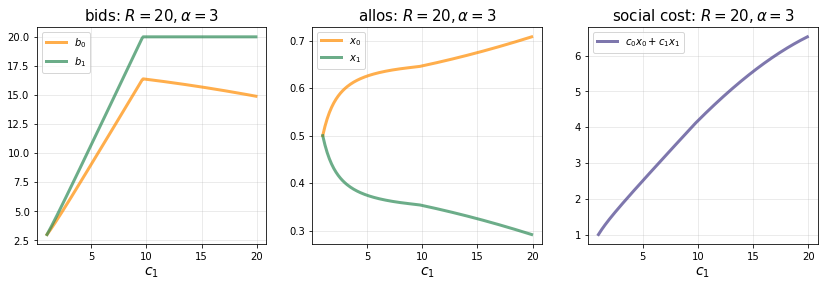

In [79]:
f, axarr = plt.subplots(ncols=3, figsize=(14,4))

colors = ['darkorange', 'seagreen', 'darkslateblue']
  
axarr[0].plot(c1s, bb[:,0], color='darkorange', linewidth=3, alpha=0.7, label=r'$b_0$')
axarr[0].plot(c1s, bb[:,1], color='seagreen', linewidth=3, alpha=0.7, label=r'$b_1$')
axarr[0].set_title(r'bids: $R={},\alpha={}$'.format(R,alpha), size=15)

axarr[1].plot(c1s, xTildes_bb[:,0], color='darkorange', linewidth=3, alpha=0.7, label=r'$x_0$')
axarr[1].plot(c1s, xTildes_bb[:,1], color='seagreen', linewidth=3, alpha=0.7, label=r'$x_1$')
axarr[1].set_title(r'allos: $R={},\alpha={}$'.format(R,alpha), size=15)

axarr[2].plot(c1s, welfares_bb, color='darkslateblue', linewidth=3, alpha=0.7, label=r'$c_0x_0+c_1x_1$')
axarr[2].set_title(r'social cost: $R={},\alpha={}$'.format(R,alpha), size=15)


for i, ax in enumerate(axarr):
    ax.legend()
    ax.grid(alpha=0.3)
    ax.set_xlabel(r'$c_1$', size=14)

plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()

# using bounded threshold

In [106]:
b0 = sp.Symbol('b0', positive=True)
R = sp.Symbol('R', positive=True)
alpha = sp.Symbol('alpha', positive=True)
N = sp.Symbol('N', positive=True)

In [107]:
u0 = ( (b0 - 1)*b0**(-alpha) ) / ( b0**(-alpha) + R**(-alpha) )
u0

(b0 - 1)/(b0**alpha*(b0**(-alpha) + R**(-alpha)))

In [119]:
from scipy.optimize import minimize_scalar

def maximize_u0(R, alpha):    
    # Define the u0 function
    def u0(b0):
        return ((b0 - 1) * b0**(-alpha)) / (b0**(-alpha) + R**(-alpha))
        # Alternatively: return (b0 - 1) / (1 + (b0 / R)**alpha)
    
    # Define the negative of u0 for minimization
    def neg_u0(b0):
        return -u0(b0)

    lower_bound = 1.01  # slightly above 1 to avoid division by zero or negative u0
    upper_bound = R * 10 if R * 10 > lower_bound else lower_bound + 10

    result = minimize_scalar(neg_u0, bounds=(lower_bound, upper_bound), method='bounded')
    
    if result.success:
        optimal_b0 = result.x
        max_u0 = u0(optimal_b0)
        print(f"Optimization successful: b0 = {optimal_b0}, u0 = {max_u0}")
        return optimal_b0
    else:
        raise RuntimeError("Optimization failed. Try different bounds or check the function.")


In [163]:
maximize_u0(R=20, alpha=3)

Optimization successful: b0 = 16.3900899672449, u0 = 9.926726600810817


16.3900899672449

In [123]:
b0 = sp.Symbol('b0', positive=True)
R = sp.Symbol('R', positive=True)
alpha = sp.Symbol('alpha', positive=True)
N = sp.Symbol('N', positive=True)

In [126]:
alpha=3
ind = 130
c1s[ind], bb[ind]

(14.00000000000001, array([15.82948018, 20.        ]))

In [127]:
# player 0 util
x0 = getAllos(bb[ind], alpha)[0]
x0, (bb[ind][0]-1)*x0

(0.6685368138804081, 9.914053431656496)

In [129]:
newbids = np.array([bb[ind][0]+0.5, bb[ind][1]])
x0 = getAllos(newbids, alpha)[0]
x0, (newbids[0]-1)*x0

(0.6475484834733384, 9.926581643590875)

In [98]:
# player 1 util
x1 = getAllos(bb[ind], alpha)[1]
x1, (bb[ind][1]-c1s[ind])*x1

(0.3314631861195919, 1.9887791167175468)

In [105]:
newbids = np.array([bb[ind][0], bb[ind][1]-0.2])
x1 = getAllos(newbids, alpha)[1]
x1, (newbids[1]-c1s[ind])*x1

(0.33817812258464125, 1.9614331109909147)

In [148]:
# both 
newbids = np.array([bb[ind][0]+0.6, bb[ind][1]])
allos = getAllos(newbids, alpha)
(newbids[0]-1)*allos[0], (newbids[1]-c1s[ind])*allos[1]

(9.926665647588925, 2.1398573907126175)

# bounding b* as a function of R,a

In [197]:
b0 = sp.Symbol('b0', positive=True)
R = sp.Symbol('R', positive=True)
alpha = sp.Symbol('alpha', positive=True)
N = sp.Symbol('N', positive=True)

u0 = ( (b0 - 1)*b0**(-alpha) ) / ( b0**(-alpha) + R**(-alpha) )
u0

(b0 - 1)/(b0**alpha*(b0**(-alpha) + R**(-alpha)))

In [198]:
foc = sp.Eq(sp.simplify(sp.diff(u0, b0)),0)
foc

Eq(R**alpha*(R**alpha*alpha*(b0 - 1) - alpha*(R**alpha + b0**alpha)*(b0 - 1) + b0*(R**alpha + b0**alpha))/(b0*(R**alpha + b0**alpha)**2), 0)

$$
(1-\alpha)b_0^{\alpha+1}+\alpha b_0^\alpha + b_0 R^\alpha 
$$

In [159]:
sp.print_latex(foc)

\frac{R^{\alpha} \left(R^{\alpha} \alpha \left(b_{0} - 1\right) - \alpha \left(R^{\alpha} + b_{0}^{\alpha}\right) \left(b_{0} - 1\right) + b_{0} \left(R^{\alpha} + b_{0}^{\alpha}\right)\right)}{b_{0} \left(R^{\alpha} + b_{0}^{\alpha}\right)^{2}} = 0


In [194]:
r_ = 50
sp.nsolve(foc.evalf(subs={R:r_, alpha:3}), r_*0.9)

40.1913788093000

In [192]:
rs = np.arange(5,50,1)
res = []
for r_ in rs:
    print(r_, end='\r')
    res.append(sp.nsolve(foc.evalf(subs={R:r_, alpha:3}), r_*0.9))
res = np.array(res)

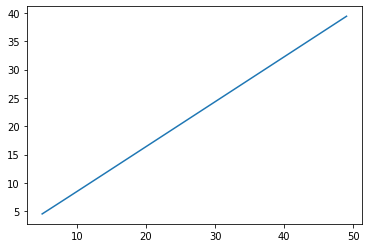

In [193]:
plt.plot(rs, res)

# numerical for diff for PoA

In [215]:
b0 = sp.Symbol('b0', positive=True)
R = sp.Symbol('R', positive=True)
alpha = sp.Symbol('alpha', positive=True)
N = sp.Symbol('N', positive=True)

u0 = ( (b0 - 1)*b0**(-alpha) ) / ( b0**(-alpha) + N*R**(-alpha) )
u0

(b0 - 1)/(b0**alpha*(N/R**alpha + b0**(-alpha)))

In [216]:
foc = sp.Eq(sp.simplify(sp.diff(u0, b0)),0)
foc

Eq(R**alpha*(R**alpha*alpha*(b0 - 1) - alpha*(b0 - 1)*(N*b0**alpha + R**alpha) + b0*(N*b0**alpha + R**alpha))/(b0*(N*b0**alpha + R**alpha)**2), 0)

In [249]:
print_latex(foc)

\frac{R^{\alpha} \left(R^{\alpha} \alpha \left(b_{0} - 1\right) - \alpha \left(b_{0} - 1\right) \left(N b_{0}^{\alpha} + R^{\alpha}\right) + b_{0} \left(N b_{0}^{\alpha} + R^{\alpha}\right)\right)}{b_{0} \left(N b_{0}^{\alpha} + R^{\alpha}\right)^{2}} = 0


In [258]:
sp.fraction(foc.lhs)[0]

R**alpha*(R**alpha*alpha*(b0 - 1) - alpha*(b0 - 1)*(N*b0**alpha + R**alpha) + b0*(N*b0**alpha + R**alpha))

In [262]:
sp.simplify(sp.fraction(foc.lhs)[0])

R**alpha*(N*alpha*b0**alpha - N*alpha*b0**(alpha + 1) + N*b0**(alpha + 1) + R**alpha*b0)

In [273]:
new = R**alpha * (N*alpha*b0**(alpha-1) - N*alpha*b0**alpha + N*b0**alpha + R**alpha)
new

R**alpha*(-N*alpha*b0**alpha + N*alpha*b0**(alpha - 1) + N*b0**alpha + R**alpha)

In [218]:
def getAllo(b0, N_, R_, alpha_):
    return b0**(-alpha_) / (b0**(-alpha_) + N_*R_**(-alpha_))

In [234]:
N_ = 3
R_ = 8
alpha_ = 4
guess = 6
eq_numeric = foc.evalf(subs={N:N_, R:R_, alpha:alpha_})
b0_star = sp.nsolve(eq_numeric, b0, guess)
b0_star

4.99192326810187

In [235]:
x0 = getAllo(b0_star, N_, R_, alpha_)
xm1 = 1-x0
x0, xm1

(0.687373545729782, 0.312626454270218)

In [236]:
PoA = x0 + N_*R_*xm1
PoA

8.19040844821501

In [239]:
def getPoA(N_, R_, alpha_, guess):
    eq_numeric = foc.evalf(subs={N:N_, R:R_, alpha:alpha_})
    b0_star = sp.nsolve(eq_numeric, b0, guess)
    x0 = getAllo(b0_star, N_, R_, alpha_)
    xm1 = 1-x0
    return x0 + N_*R_*xm1

In [240]:
getPoA(3., 8., 4., guess=4.)

8.19040844821501

In [324]:
rs = [2, 4, 8]
ns = np.arange(1, 20)
alphas = [3, 4, 5]
guesses = [1.5, 2, 4]

poas = []
for i, R_ in enumerate(rs):
    temp = []
    for N_ in ns:
        temp2 = []
        for alpha_ in alphas:
            # print(N_, R_, alpha_)
            temp2.append(getPoA(N_, R_, alpha_, guesses[i]))
        temp.append(temp2)
    poas.append(temp)
poas = np.array(poas)
poas.shape

(3, 19, 3)

In [325]:
def getHonestAllos(N_, R_, alpha_):
    costs = [R_]*N_
    costs.append(1.)
    costs = np.array(costs)
    return costs, costs**(-alpha_) / sum(costs**(-alpha_))

In [326]:
getHonestAllos(5,5,3)

(array([5., 5., 5., 5., 5., 1.]),
 array([0.00769231, 0.00769231, 0.00769231, 0.00769231, 0.00769231,
        0.96153846]))

In [327]:
welfares = [] 
for i, R_ in enumerate(rs):
    temp = []
    for N_ in ns:
        temp2 = []
        for alpha_ in alphas:
            costs, allos = getHonestAllos(N_, R_, alpha_)
            social_cost = np.dot(costs, allos)
            temp2.append(social_cost)
        temp.append(temp2)
    welfares.append(temp)
welfares = np.array(welfares)
welfares.shape

(3, 19, 3)

In [328]:
costs, allos = getHonestAllos(5, 5, 3)
costs, allos, np.dot(costs, allos)

(array([5., 5., 5., 5., 5., 1.]),
 array([0.00769231, 0.00769231, 0.00769231, 0.00769231, 0.00769231,
        0.96153846]),
 1.1538461538461537)

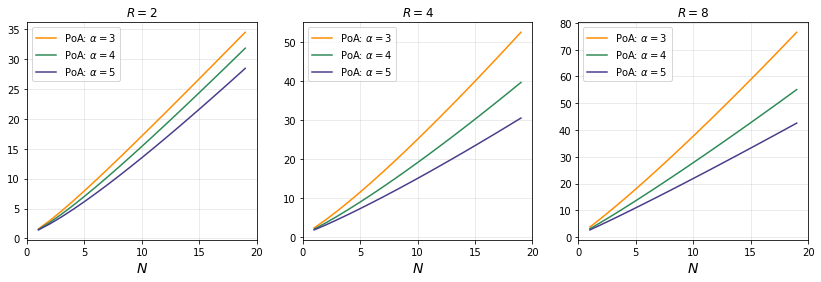

In [329]:
f, axarr = plt.subplots(ncols=3, figsize=(14,4))

colors = ['darkorange', 'seagreen', 'darkslateblue']
for i in range(3):
#     axarr[i].plot(ns, 1+ns*rs[i], color='black')
    for j in range(3):
        axarr[i].plot(ns, poas[i,:,j], label=r'PoA: $\alpha=${}'.format(alphas[j]), color=colors[j])

    
for i, ax in enumerate(axarr):
    ax.legend()
    ax.grid(alpha=0.3)
    ax.set_xticks(np.arange(0,21,5))
    ax.set_xlabel(r'$N$', size=14)
    ax.set_title(r'$R={}$'.format(rs[i], size=14))

# plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()

In [330]:
# Define symbols
x, c, a, N = sp.symbols('x c a N')

# Define the original equation
lhs = c * (a - a*x - 1) / ((a*(N - 1))/N + (a*x)/N - 1)
rhs = (N**(1 + 1/a) * (a*(1 - x) + 2*x -1)) / (a*(N + x -1))

# Form the equation
equation = sp.Eq(lhs, rhs)
equation

Eq(c*(-a*x + a - 1)/(-1 + a*x/N + a*(N - 1)/N), N**(1 + 1/a)*(a*(1 - x) + 2*x - 1)/(a*(N + x - 1)))

In [331]:
quadratic_eq = sp.simplify(equation.lhs - equation.rhs)
quadratic_eq

(-N*a*c*(N + x - 1)*(a*x - a + 1) + N**((a + 1)/a)*(-N + a*x + a*(N - 1))*(a*(x - 1) - 2*x + 1))/(a*(-N + a*x + a*(N - 1))*(N + x - 1))

In [332]:
# Solve for x
roots_sym = sp.solve(quadratic_eq, x)
roots_sym[1]

(-N**2*a**2*c + 2*N*a**2*c - N*a*c - 2*N**(1 + 1/a)*a**2 + 3*N**(1 + 1/a)*a + N**(2 + 1/a)*a**2 - 3*N**(2 + 1/a)*a + 2*N**(2 + 1/a) + sqrt(N**4*a**4*c**2 - 2*N**3*a**3*c**2 + N**2*a**2*c**2 + 2*N**(2 + 1/a)*a**2*c + N**(2 + 2/a)*a**2 + 2*N**(3 + 1/a)*a**2*c - 4*N**(3 + 1/a)*a*c + 2*N**(3 + 2/a)*a**3 - 6*N**(3 + 2/a)*a**2 + 4*N**(3 + 2/a)*a - 2*N**(4 + 1/a)*a**4*c + 6*N**(4 + 1/a)*a**3*c - 4*N**(4 + 1/a)*a**2*c + N**(4 + 2/a)*a**4 - 6*N**(4 + 2/a)*a**3 + 13*N**(4 + 2/a)*a**2 - 12*N**(4 + 2/a)*a + 4*N**(4 + 2/a)))/(2*a*(N*a*c - N**(1 + 1/a)*a + 2*N**(1 + 1/a)))

In [333]:
sp.print_latex(roots_sym[1])

\frac{- N^{2} a^{2} c + 2 N a^{2} c - N a c - 2 N^{1 + \frac{1}{a}} a^{2} + 3 N^{1 + \frac{1}{a}} a + N^{2 + \frac{1}{a}} a^{2} - 3 N^{2 + \frac{1}{a}} a + 2 N^{2 + \frac{1}{a}} + \sqrt{N^{4} a^{4} c^{2} - 2 N^{3} a^{3} c^{2} + N^{2} a^{2} c^{2} + 2 N^{2 + \frac{1}{a}} a^{2} c + N^{2 + \frac{2}{a}} a^{2} + 2 N^{3 + \frac{1}{a}} a^{2} c - 4 N^{3 + \frac{1}{a}} a c + 2 N^{3 + \frac{2}{a}} a^{3} - 6 N^{3 + \frac{2}{a}} a^{2} + 4 N^{3 + \frac{2}{a}} a - 2 N^{4 + \frac{1}{a}} a^{4} c + 6 N^{4 + \frac{1}{a}} a^{3} c - 4 N^{4 + \frac{1}{a}} a^{2} c + N^{4 + \frac{2}{a}} a^{4} - 6 N^{4 + \frac{2}{a}} a^{3} + 13 N^{4 + \frac{2}{a}} a^{2} - 12 N^{4 + \frac{2}{a}} a + 4 N^{4 + \frac{2}{a}}}}{2 a \left(N a c - N^{1 + \frac{1}{a}} a + 2 N^{1 + \frac{1}{a}}\right)}


In [29]:
roots = np.array([roots_sym[1].evalf(subs={N:N_, a:alpha, c:c1}) for c1 in c1s])

In [340]:
roots = [] 
for i, R_ in enumerate(rs):
    temp = []
    for N_ in ns:
        temp2 = []
        for alpha_ in alphas:
            root = roots_sym[1].evalf(subs={N:N_, a:alpha_, c:R_})
            val = root + R_*(1-root)
            temp2.append(val)
        temp.append(temp2)
    roots.append(temp)
roots = np.array(roots)
roots.shape

(3, 19, 3)

In [364]:
R_     = 2.
welfares = []
for N_ in ns:
    temp = []
    for alpha_ in alphas:
        costs   = [1]
        costs.extend([R_]*N_)
        bids    = getEquilBids(costs, a=alpha_, guess=costs)
        xTilde  = getAllos(bids, a=alpha_)
        temp.append(np.dot(costs, xTilde))
    welfares.append(temp)
welfares = np.array(welfares)
welfares.shape

(19, 3)

In [372]:
R_     = 4.
welfares4 = []
for N_ in ns:
    temp = []
    for alpha_ in alphas:
        costs   = [1]
        costs.extend([R_]*N_)
        guesses   = [2]
        guesses.extend([R_]*N_)
        bids    = getEquilBids(costs, a=alpha_, guess=guesses)
        xTilde  = getAllos(bids, a=alpha_)
        temp.append(np.dot(costs, xTilde))
    welfares4.append(temp)
welfares4 = np.array(welfares4)
welfares4.shape

(19, 3)

In [385]:
R_     = 8.
welfares8 = []
for N_ in ns:
    temp = []
    for alpha_ in alphas:
        costs   = [1]
        costs.extend([R_]*N_)
        guesses   = [3]
        guesses.extend([R_]*N_)
        bids    = getEquilBids(costs, a=alpha_, guess=guesses)
        xTilde  = getAllos(bids, a=alpha_)
        temp.append(np.dot(costs, xTilde))
    welfares8.append(temp)
welfares8 = np.array(welfares8)
welfares8.shape

(19, 3)

In [392]:
# EXAMPLE
N_     = 15
R_     = 8
alpha_ = 3
costs   = [1]
costs.extend([R_]*N_)
guesses   = [3]
guesses.extend([R_]*N_)
bids= getEquilBids(costs, a=alpha_, guess=guesses)
bids

array([ 4.48874627, 12.17923862, 12.17923862, 12.17923862, 12.17923862,
       12.17923862, 12.17923862, 12.17923862, 12.17923862, 12.17923862,
       12.17923862, 12.17923862, 12.17923862, 12.17923862, 12.17923862,
       12.17923862])

In [393]:
xTilde  = getAllos(bids, a=alpha_)
xTilde

array([0.57112136, 0.02859191, 0.02859191, 0.02859191, 0.02859191,
       0.02859191, 0.02859191, 0.02859191, 0.02859191, 0.02859191,
       0.02859191, 0.02859191, 0.02859191, 0.02859191, 0.02859191,
       0.02859191])

In [395]:
costs

[1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]

In [394]:
np.dot(costs, xTilde)

4.002150481227024

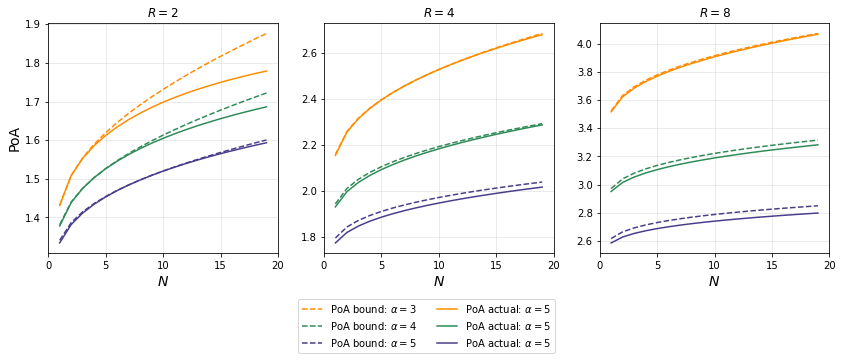

In [391]:
f, axarr = plt.subplots(ncols=3, figsize=(14,5))

colors = ['darkorange', 'seagreen', 'darkslateblue']
for i in range(3):
    for j in range(3):
        axarr[i].plot(ns, roots[i,:,j], label=r'PoA bound: $\alpha=${}'.format(alphas[j]),
                      color=colors[j], linestyle='--')

for i in range(3):
    axarr[0].plot(ns, welfares[:,i], color=colors[i], label=r'PoA actual: $\alpha=${}'.format(alphas[j]))
    axarr[1].plot(ns, welfares4[:,i], color=colors[i], label=r'PoA actual: $\alpha=${}'.format(alphas[j]))
    axarr[2].plot(ns, welfares8[:,i], color=colors[i], label=r'PoA actual: $\alpha=${}'.format(alphas[j]))
    
for i, ax in enumerate(axarr):
    ax.grid(alpha=0.3)
    ax.set_xticks(np.arange(0,21,5))
    ax.set_xlabel(r'$N$', size=14)
    ax.set_title(r'$R={}$'.format(rs[i], size=20))

handles, labels = axarr[0].get_legend_handles_labels()
f.legend(
    handles, 
    labels, 
    loc='lower center', 
    ncol=2, 
    bbox_to_anchor=(0.5, -0.05),  # Adjust the position as needed
    fontsize='medium'
)
axarr[0].set_ylabel('PoA', size=14)
plt.subplots_adjust(bottom=0.24)

plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()

# Bounding b_0

In [277]:
foc

Eq(R**alpha*(R**alpha*alpha*(b0 - 1) - alpha*(b0 - 1)*(N*b0**alpha + R**alpha) + b0*(N*b0**alpha + R**alpha))/(b0*(N*b0**alpha + R**alpha)**2), 0)

In [276]:
def getbstar(N_, R_, alpha_, guess):
    eq_numeric = foc.evalf(subs={N:N_, R:R_, alpha:alpha_})
    return sp.nsolve(eq_numeric, b0, guess)

In [295]:
getbstar(12., 4., 3., 2.)

2.10297606448782

In [283]:
alpha_ = 3
R_     = 4
ns     = np.arange(1, 20)

In [296]:
bstars = []
for N_ in ns:
    print(N_,R_,alpha_, end='\r')
    bstars.append(getbstar(N_, R_, alpha_, 0.5*R_))
bstars = np.array(bstars)
bstars.shape

(19,)

In [300]:
def bstarbound(N_, R_, alpha_):
    return (R_**alpha_ / N_ + (alpha_-1)**2)/((alpha_ - 1)*alpha_)

In [304]:
def bstarbound(N_, R_, alpha_):
    return (R_**alpha_/(N_*(alpha_-1)))**(1/alpha_)

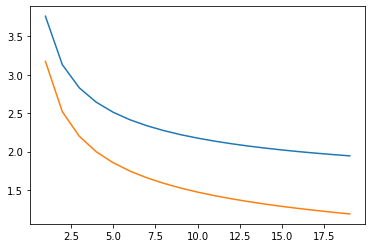

In [305]:
plt.plot(ns, bstars)
plt.plot(ns, bstarbound(ns, R_, alpha_))

In [309]:
alpha, b0, N, R

(alpha, b0, N, R)

In [313]:
eq = sp.Eq((alpha-1)*(1+alpha*(b0-1))-alpha*(1+(alpha-1)*(b0-1)), R**alpha/N)
eq

Eq(-alpha*((alpha - 1)*(b0 - 1) + 1) + (alpha - 1)*(alpha*(b0 - 1) + 1), R**alpha/N)

In [314]:
sp.solve(eq, b0)

[]

In [320]:
poas = []
poas2 = []
for i, N_ in enumerate(ns):
    print(N_,R_,alpha_, end='\r')
    x0 = getAllo(bstars[i], N_, R_, alpha_)
    xm1 = 1-x0
    poas.append(x0 + N_*R_*xm1)
    
    xb = bstarbound(N_, R_, alpha_)
    xm1 = 1-xb
    poas2.append(xb + N_*R_*xm1)
poas = np.array(poas)
poas.shape

(19,)

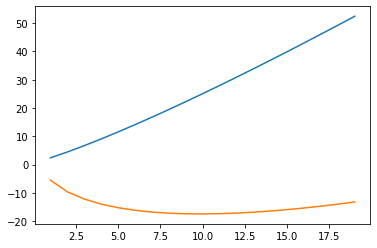

In [322]:
plt.plot(ns, poas)
plt.plot(ns, poas2)